# Exacting Strike

**The question we want to answer:**
*"I'm a level 5 fighter with a +1 Striking Maul. What's my average damage? Is Exacting Strike a good feat?"*

Let's simulate striking 3 times in a round, against a target that is not off-guard.
On your second strike, you _may_ use Exacting Strike. If you do, the outcome changes the MAP on your third strike.
Every time you roll a critical hit, the target needs to pass a fortitude save or be knocked prone.
If they're knocked prone, they become flat-footed to the following attacks, and they will have to stand on the next round, provoking a Reactive Strike.

In [1]:
import numpy
import xarray
from pathfinder2e_stats import *

numpy.random.seed(0)

Let's define three targets:

- a mook that's 2 levels below us, low AC, and low fortitude (GMC pp. TODO)
- a monster at our same level, medium AC, and medium fortitude
- a boss that's 2 levels above us, high AC, and high fortitude

In [2]:
targets = xarray.Dataset(
    data_vars={
        "AC": ("target", [16, 21, 25]), 
        "fortitude": ("target", [6, 12, 18]),
    },
    coords={"target": ["level 3 low", "level 5 medium", "level 7 high"]},
)
targets.to_pandas()

,AC,fortitude
target,,
level 3 low,16,6
level 5 medium,21,12
level 7 high,25,18


Then we define our own stats.

**Note:** the same way we defined multiple targets using an xarray.Dataset, we could have multiple attackers, for example a fighter vs. a barbarian.

In [3]:
attack_bonus = 5 + 6 + 4 + 1  # Level 5, master, STR+4, item+1
class_DC = 10 + 5 + 2 + 4  # Level 5, trained, STR+4
attack_bonus, class_DC

(16, 21)

Then we create a damage profile for our weapon.

In [4]:
damage_spec = Damage("bludgeoning", 2, 12, 4)

First strike!

In [5]:
strike1 = damage(
    check(attack_bonus, DC=targets.AC),
    damage_spec,
)
strike1

<xarray.Dataset> Size: 8MB
Dimensions:        (target: 3, roll: 100000, damage_type: 1)
Coordinates:
  * target         (target) <U14 168B 'level 3 low' ... 'level 7 high'
  * damage_type    (damage_type) <U11 44B 'bludgeoning'
Dimensions without coordinates: roll
Data variables:
    bonus          int64 8B 16
    DC             (target) int64 24B 16 21 25
    natural        (roll) int64 800kB 13 16 1 4 4 8 10 20 ... 17 9 1 11 3 12 10
    outcome        (roll, target) int64 2MB 2 1 1 2 2 1 0 -1 ... 0 0 2 1 1 2 1 1
    direct_damage  (roll, target, damage_type) int64 2MB 28 17 17 ... 40 15 15
    total_damage   (roll, target) int64 2MB 28 17 17 40 40 24 ... 16 16 40 15 15
Attributes:
    keen:         False
    fortune:      False
    misfortune:   False
    hero_point:   False
    legend:       {-2: 'No roll', -1: 'Critical failure', 0: 'Failure', 1: 'S...
    damage_spec:  {'Success': '2d12+4 bludgeoning', 'Critical success': '(2d1...

The target must roll a Fortitude save after every critical hit or be knocked prone.
Let's pre-roll them in advance as the bonus and DC don't change.

In [6]:
fort_saves = check(
    bonus=targets.fortitude,
    DC=class_DC,
    allow_critical_success=False,
    allow_critical_failure=False,
    dims={"strike": 4},
)
fort_saves.coords["strike"] = [1, 2, 3, "reactive"]
knocked_prone = (fort_saves.outcome == DoS.failure)
knocked_prone.mean("roll").to_pandas()

target,level 3 low,level 5 medium,level 7 high
strike,,,
1,0.69994,0.40092,0.10139
2,0.70044,0.39910,0.10124
3,0.69830,0.39616,0.10023
reactive,0.70152,0.39925,0.09989


Calculate the chance of being knocked prone by the first strike

In [7]:
knocked_prone_1 = (
    knocked_prone.sel(strike="1", drop=True)
    .where(strike1.outcome == DoS.critical_success, False)
)
knocked_prone_1.mean("roll").to_pandas()

target
level 3 low       0.38481
level 5 medium    0.11960
level 7 high      0.01000
dtype: float64

Second strike! The AC changes depending if the target has been knocked prone by the first strike or not.

In [8]:
strike2 = damage(
    check(attack_bonus - 5, DC=targets.AC - knocked_prone_1 * 2),
    damage_spec,
)
knocked_prone_2 = (
    knocked_prone.sel(strike="2", drop=True)
    .where(strike2.outcome == DoS.critical_success, False)
) | knocked_prone_1
knocked_prone_2.mean("roll").to_pandas()

target
level 3 low       0.51472
level 5 medium    0.13715
level 7 high      0.01530
dtype: float64

Strike 3! We want to investigate the benefit of Exacting Strike. So, from now on we're going to roll everything twice, with and without the feat.

In [9]:
MAP3 = xarray.concat(
    [xarray.DataArray(10), xarray.where(strike2.outcome == DoS.failure, 5, 10)],
    dim="exacting_strike",
)
MAP3.coords["exacting_strike"] = [False, True]

strike3 = damage(
    check(attack_bonus - MAP3, DC=targets.AC - knocked_prone_2 * 2),
    damage_spec,
)
knocked_prone_3 = (
    knocked_prone.sel(strike="3", drop=True)
    .where(strike3.outcome == DoS.critical_success, False)
) | knocked_prone_2
knocked_prone_3.mean("roll").to_pandas()

exacting_strike,False,True
target,,
level 3 low,0.53211,0.54820
level 5 medium,0.15454,0.15454
level 7 high,0.02030,0.02030


And finally the reactive strike, which happens only if the target is prone by the end of the round

In [10]:
reactive_strike_check = check(attack_bonus, DC=targets.AC)
reactive_strike_check["outcome"] = reactive_strike_check.outcome.where(knocked_prone_3, DoS.no_roll)
reactive_strike = damage(reactive_strike_check, damage_spec)

knocked_prone_by_reactive_strike = (
    knocked_prone
    .sel(strike="reactive", drop=True)
    .where(reactive_strike.outcome == DoS.critical_success, False)
)
knocked_prone_by_reactive_strike.mean("roll").to_pandas()

exacting_strike,False,True
target,,
level 3 low,0.20465,0.21059
level 5 medium,0.01859,0.01859
level 7 high,0.00026,0.00026


We're done! Let's assemble our aggregated object.

In [11]:
all_strikes = xarray.concat(
    [strike1, strike2, strike3, reactive_strike],
    dim="strike"
)
all_strikes.coords["strike"] = fort_saves.strike
all_strikes["prone_at_end_of_round"] = knocked_prone_3
all_strikes["prone_on_reactive_strike"] = knocked_prone_by_reactive_strike
all_strikes

<xarray.Dataset> Size: 91MB
Dimensions:                   (strike: 4, exacting_strike: 2, roll: 100000,
                               target: 3, damage_type: 1)
Coordinates:
  * target                    (target) <U14 168B 'level 3 low' ... 'level 7 h...
  * damage_type               (damage_type) <U11 44B 'bludgeoning'
  * exacting_strike           (exacting_strike) bool 2B False True
  * strike                    (strike) <U21 336B '1' '2' '3' 'reactive'
Dimensions without coordinates: roll
Data variables:
    bonus                     (strike, exacting_strike, roll, target) int64 19MB ...
    DC                        (strike, target, roll) int64 10MB 16 16 ... 25 25
    natural                   (strike, roll) int64 3MB 13 16 1 4 4 ... 8 10 6 12
    outcome                   (strike, roll, target, exacting_strike) int64 19MB ...
    direct_damage             (strike, roll, target, damage_type, exacting_strike) int64 19MB ...
    total_damage              (strike, roll, target, exacting_strike) int64 19MB ...
    prone_at_end_of_round     (roll, target, exacting_strike) bool 600kB True...
    prone_on_reactive_strike  (roll, target, exacting_strike) bool 600kB Fals...
Attributes:
    keen:         False
    fortune:      False
    misfortune:   False
    hero_point:   False
    legend:       {-2: 'No roll', -1: 'Critical failure', 0: 'Failure', 1: 'S...
    damage_spec:  {'Success': '2d12+4 bludgeoning', 'Critical success': '(2d1...

We can finally aggregate our measures to gather insights.

In [12]:
agg_measures = (
    all_strikes
    .sum("strike")
    .mean("roll")
    [["total_damage", "prone_at_end_of_round", "prone_on_reactive_strike"]]
)
agg_measures["any_damage"] = (all_strikes["total_damage"].sum("strike") > 0).mean("roll")
agg_measures
agg_measures.stack(idx=["target", "exacting_strike"]).to_pandas()

total_damage  prone_at_end_of_round  \
target         exacting_strike                                        
level 3 low    False                71.06828                0.53211   
               True                 72.44391                0.54820   
level 5 medium False                38.33123                0.15454   
               True                 40.03094                0.15454   
level 7 high   False                21.54167                0.02030   
               True                 23.45239                0.02030   

                                prone_on_reactive_strike  any_damage  \
target         exacting_strike                                         
level 3 low    False                             0.20465     0.99517   
               True                              0.21059     0.99753   
level 5 medium False                             0.01859     0.93671   
               True                              0.01859     0.95711   
level 7 high   False                             0.00026     0.76459   
               True                              0.00026     0.81007   

                                        target  exacting_strike  
target         exacting_strike                                   
level 3 low    False               level 3 low            False  
               True                level 3 low             True  
level 5 medium False            level 5 medium            False  
               True             level 5 medium             True  
level 7 high   False              level 7 high            False  
               True               level 7 high             True

What's the % benefit of exacting strike compared to three regular strikes?

In [13]:
(agg_measures.sel(exacting_strike=True) / agg_measures.sel(exacting_strike=False)).to_pandas()

,total_damage,prone_at_end_of_round,prone_on_reactive_strike,any_damage
target,,,,
level 3 low,1.019356,1.030238,1.029025,1.002371
level 5 medium,1.044343,1.000000,1.000000,1.021778
level 7 high,1.088699,1.000000,1.000000,1.059483


The answer to the original question, _is Exacting Strike a good feat?_ is that it's quite inconsequential against weak enemies but, if you start your round in striking range of a boss and you've got nothing better to do with your third action, it will yield a solid 9% damage boost on average and will let you deal _some_ damage 6% more frequently.

In almost all cases it's inconsequential fort the purpose of triggering special abilities that go off on critical hits (you'd need to crit on a 19 on the die or less, while at MAP-5, for it to matter).


What's the damage distribution?

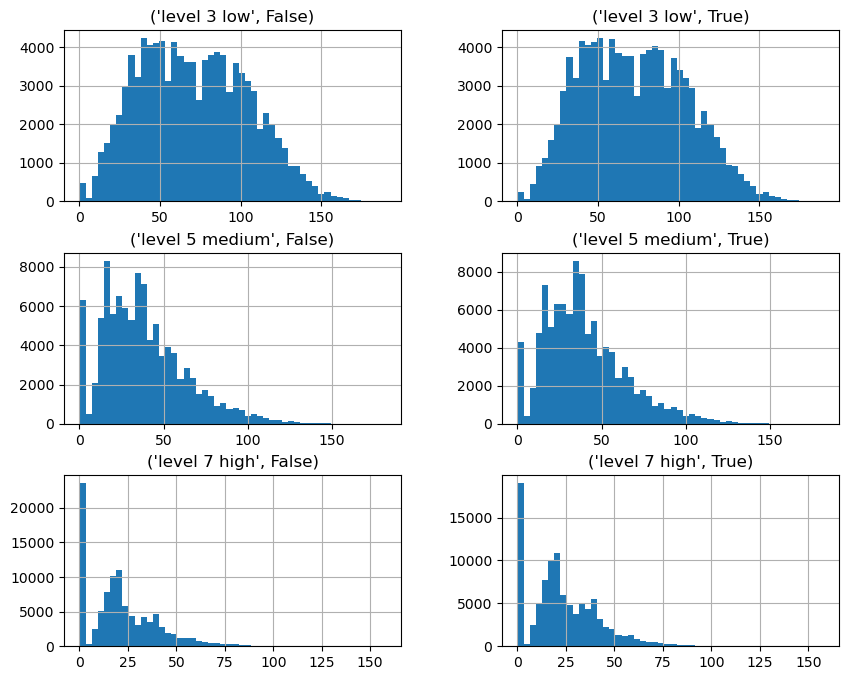

In [14]:
_ = (
    all_strikes["total_damage"]
    .sum("strike")
    .stack(idx=["target", "exacting_strike"])
    .to_pandas()
    .hist(bins=50, figsize=(10, 8))
)

## Homework

- How does Exacting Strike perform compared to Vicious Swing?
- What's better, a sword (off-guard on a crit, no save) or a hammer (prone on a crit and trigger Reactive Strike, but with save)?
- How does a two-hander (e.g. maul) perform compared to two one-handers (e.g. warhammer and light hammer) with Double Slice?
- What's the damage distribution of a barbarian vs. that of a fighter?
- How much extra damage, on average, does a +1 to hit (or a -1 to AC) yield?

## Last words
In real play, circumstance is everything. For example, Exacting Strike is worthless when you have to spend one action moving into position (at least until you start getting Hasted with some consistency). Knocking a target prone is much more valuable if there are multiple martials with Reactive Strike, Stand Still, or similar feats in the party. Making a target off-guard is a lot more valuable if there's a rogue in party; etc. etc. 